In [3]:
import sys
import torch
from abcpy.output import Journal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from tqdm import tqdm
from src.models.g_and_k_model import uni_g_and_k
from src.scoring_rules.scoring_rules import EnergyScore, KernelScore 
from src.transformers import BoundedVarTransformer
import functools

torch.set_default_dtype(torch.float64)

In [4]:
def joint_log_prob(param_torch_unconstrained, obs, model, scoring_rule, transformer, n_samples_per_param=500):
    # 1. Transform to constrained space
    # 2. Calculate LAJ (unconstrained)
    # 3. Calculate log prior (constrained)
    # 4. Calculate log likelihood / score (constrained) (weights should be initialised in the scoring rule class)

    param_torch_constrained = transformer.inverse_transform(param_torch_unconstrained, use_torch=True)
    # LAJ
    laj = transformer.jac_log_det_inverse_transform(param_torch_unconstrained, use_torch=True)

    # Log prior
    log_prior = 0 #Uniform prior

    # Log likelihood    
    sims = model.torch_forward_simulate(param_torch_constrained, n_samples_per_param)
    log_ll = scoring_rule.loglikelihood(y_obs = obs, y_sim = sims, use_torch=True)
    #model.scores.append(log_ll.detach()) #Detach otherwise mem explodes!

    return laj + log_prior + log_ll

In [7]:
# Transformer for parameters
L = np.array([0,0,0,0])
U = np.array([4,4,4,4])
b = BoundedVarTransformer(lower_bound=L, upper_bound=U)

# Energy Scoring Rule
es = EnergyScore(weight=1)

# obs   
obs = np.load("./gk_obs_0.npy")
print(obs.shape)
obs = torch.from_numpy(obs)[:10]

# Model
gk = uni_g_and_k()

joint_log_prob_func = functools.partial(joint_log_prob, model=gk, scoring_rule=es, transformer=b)

def est_grad(param_torch, data):
    p = param_torch.detach()
    p.requires_grad = True

    # Calculate gradient
    op = joint_log_prob_func(p, data)
    op.backward()

    param_grad = p.grad.numpy()
    return param_grad

(1000, 1)


In [8]:
# Get results
ss_pm_10 = Journal.fromFile('./EnergyScore_MCMC_burnin_0_n-samples_110000_n-sam-per-param_500_n-sam-in-obs_10.jnl')
ss_pm_10 = np.array(ss_pm_10.accepted_parameters).reshape(110000,4)

with open('sgnht_gk_obs-10_exp-0_es.pkl', 'rb') as handle:
    ss_sg_10 = pickle.load(handle)

In [9]:
# Get transformer from SG
trans = ss_sg_10['config']['transformer']

In [10]:
ss_pm_10_grads = []
for param in tqdm(ss_pm_10[:30000]):
    param = torch.tensor(np.array(trans.transform(param)))
    grad = est_grad(param, obs)
    ss_pm_10_grads.append(grad)

100%|██████████| 30000/30000 [07:58<00:00, 62.65it/s]


In [11]:
ss_sg_10_grads = []
for param in tqdm(ss_sg_10['samples_uncon'][:30000]):
    grad = est_grad(param, obs)
    ss_sg_10_grads.append(grad)

100%|██████████| 30000/30000 [06:26<00:00, 77.60it/s] 


In [12]:
ss_pm_10_grads = torch.tensor(np.array(ss_pm_10_grads))
ss_sg_10_grads = torch.tensor(np.array(ss_sg_10_grads))
ss_pm_10_samples = torch.tensor([np.array(trans.transform(param)) for param in ss_pm_10[:30000]]) # Need this in the unconstrained space

/tmp/ipykernel_366748/2756524727.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  ss_pm_10_samples = torch.tensor([np.array(trans.transform(param)) for param in ss_pm_10[:30000]]) # Need this in the unconstrained space


In [13]:
from sgmcmcjax.ksd import imq_KSD

x_pm = list(range(1000,31000,1000))
y_pm = []
for i in tqdm(x_pm):
    y_pm.append(imq_KSD(ss_pm_10_samples[:i].numpy(), ss_pm_10_grads[:i].numpy()).item())
x_sg = list(range(1000,31000,1000))
y_sg = []
for i in tqdm(x_sg):
    y_sg.append(imq_KSD(ss_sg_10['samples_uncon'][:i].numpy(), ss_sg_10_grads[:i].numpy())
    .item())

100%|██████████| 30/30 [05:54<00:00, 11.81s/it]


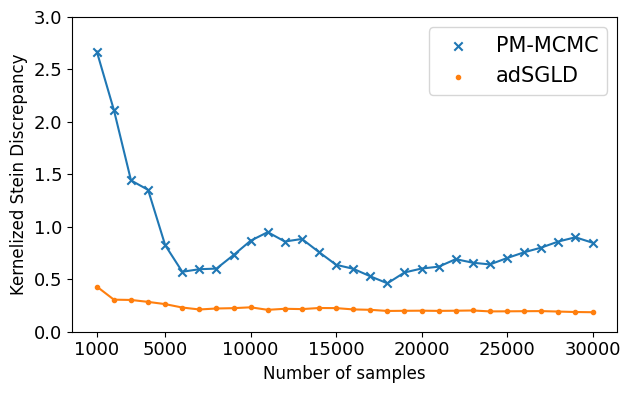

In [14]:
params = {
   'text.usetex': False,
   'figure.figsize': [6.4, 4],
    'font.size': 9,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'legend.fontsize': 15,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
   }

import matplotlib as mpl
with mpl.rc_context(params):
    #color = "0"
    fig, ax = plt.subplots()

    plt.scatter(x_pm,y_pm, marker='x', label='PM-MCMC')
    plt.plot(x_pm,y_pm)#, ls='-.')

    plt.scatter(x_sg, y_sg, marker='.', label='adSGLD')
    plt.plot(x_sg,y_sg)

    plt.legend(loc='upper right')
    plt.xlabel('Number of samples')
    ax.set_xticks(np.append(1000, np.arange(5000,31000,5000)))
    ax.set_ylim(0,3)
    plt.ylabel('Kernelized Stein Discrepancy') 
    fig.tight_layout()#rect=[0.2,0.2,.2,.2]) 
    plt.savefig("KSD Between PM and SG g-and-k 10 obs.pdf", bbox_inches='tight')


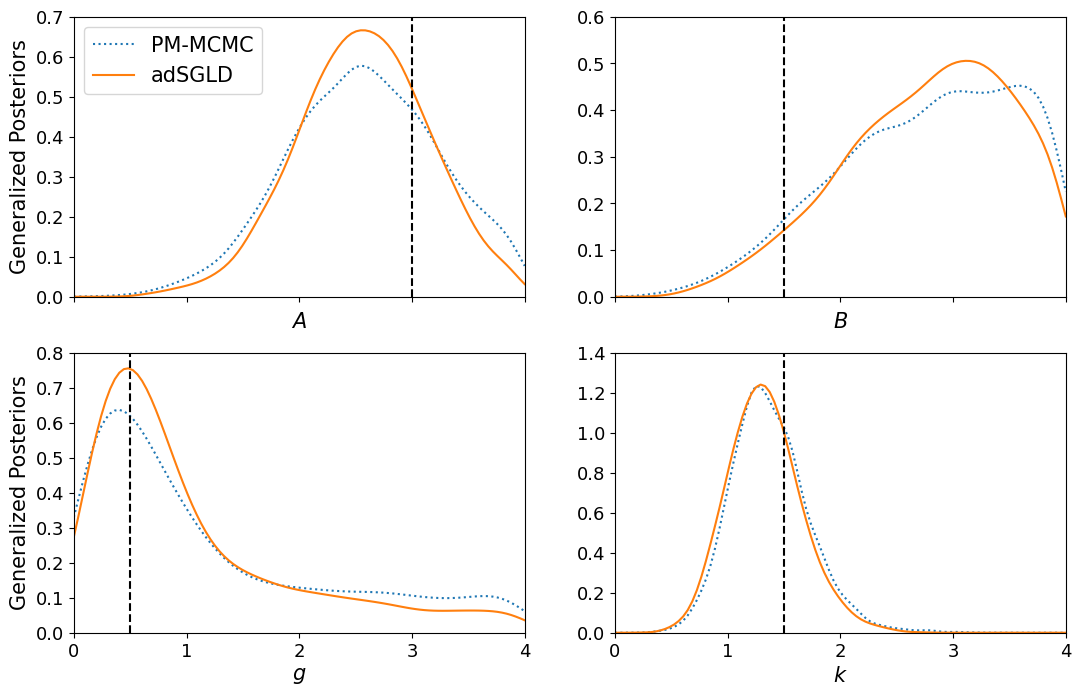

In [15]:
from scipy.stats import gaussian_kde

params = {
   'text.usetex': False,
   'figure.figsize': [6.4, 4],
    'font.size': 9,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 15,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
   }

from matplotlib.ticker import FormatStrFormatter

y_maxes = [0.7,0.6,0.8,1.4]

with mpl.rc_context(params):
    smoothing = 0.2
    mid = [3., 1.5,0.5,1.5]

    xlab_leg = [r'$A$', r'$B$', r'$g$', r'$k$']
    fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(12.8,8))
    #fig.set_size_inches(45, 10.5)
    #fig.subplots_adjust(hspace=0.2)

    for idx, ax_idx in enumerate([(0,0),(0,1),(1,0),(1,1)]):
        axs[ax_idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        post_samples = ss_pm_10[30000:,idx]
        positions = np.linspace(0, 4, 100)
        gaussian_kernel = gaussian_kde(post_samples)
        gaussian_kernel.covariance_factor = lambda : smoothing
        gaussian_kernel._compute_covariance()

        axs[ax_idx].plot(positions, gaussian_kernel(positions), ls=":", label="PM-MCMC")

        post_samples = trans.inverse_transform(ss_sg_10["samples_uncon"], use_torch=True)[30000:,idx].numpy()
        positions = np.linspace(0, 4, 100)
        gaussian_kernel = gaussian_kde(post_samples)
        gaussian_kernel.covariance_factor = lambda : smoothing
        gaussian_kernel._compute_covariance()

        axs[ax_idx].plot(positions, gaussian_kernel(positions), label="adSGLD")

        axs[ax_idx].set_ylim(ymin=0,ymax=y_maxes[idx])
        axs[ax_idx].set_xlim([0,4])
        if ax_idx in [(0,0), (1,0)]:
            axs[ax_idx].set_ylabel('Generalized Posteriors') 
        else:
            axs[ax_idx].set_ylabel('') 
        axs[ax_idx].get_xaxis().set_ticks(range(0,5))
        if ax_idx not in [(1,0), (1,1)]:
            axs[ax_idx].get_xaxis().set_ticklabels([])

        axs[ax_idx].set_xlabel(xlab_leg[idx])
        axs[ax_idx].axvline(x=mid[idx], color='k', linestyle='--')
    axs[(0,0)].legend(loc='upper left')
    #fig.subplots_adjust(hspace=0.5)
    plt.savefig("Marginal Posterior between SG and PM g-and-k 10 obs.pdf", bbox_inches='tight')